In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import numpy as np
from pathlib import Path
from torchsummary import summary
torch.set_printoptions(sci_mode=False)

In [2]:
PATH = Path("dataset") / "GTSRB" / "Training"
torch.set_float32_matmul_precision('high')
LABELS = ["20 km/h"
,"30 km/h"
,"50 km/h"
,"60 km/h"
,"70 km/h"
,"80 km/h"
,"End of speed limit"
,"100 km/h"
,"120 km/h"
,"No passing"
,"No passing for large vehicles"
,"Right of way"
,"Priority road"
,"Yield"
,"Stop"
,"No vehicles"
,"Large vehicles prohibited"
,"No entry"
,"General caution"
,"Dangerous curve to the left"
,"Dangerous curve to the right"
,"Double curve"
,"Bumpy road"
,"Slippery road"
,"Road narrows"
,"Road work"
,"Traffic signals"
,"Pedestrians"
,"Children crossing"
,"Bicycle crossing"
,"Ice warning"
,"Wild animals crossing"
,"End of all speed and passing limits"
,"Turn right ahead"
,"Turn left ahead"
,"Ahead only"
,"Go straight or right"
,"Go straight or left"
,"Keep right"
,"Keep left"
,"Roundabout mandatory"
,"End of no passing"
,"End of no passing by large vehicles"]

In [3]:
_N = 32
batch_size = 256
n_classes = 43
epochs = 30
device = "cuda"#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def get_mean_std():
    transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    ])
    dataset = torchvision.datasets.ImageFolder(root=PATH,transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total = 0
    for images,_ in dataloader: # load a batch at a time
        n = images.size(0)
        total += 1
        mean  += images.mean(dim=[0,2,3])
        std   += images.std(dim=[0,2,3])
    std  /= total
    mean /= total
    return mean,std
# get_mean_std() # (tensor([0.3397, 0.3117, 0.3210]), tensor([0.2299, 0.2247, 0.2332]))

In [5]:
mean = torch.tensor([0.3397, 0.3117, 0.3210])
std = torch.tensor([0.2299, 0.2247, 0.2332])

def to_image(img): # convert to unormalized form for viewing
    _mean = mean.view(3,1,1)
    _std = std.view(3,1,1)
    return (img * _std + _mean).permute(1,2,0).numpy()
normalise = transforms.Normalize(mean, std)
transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    normalise
])

In [6]:
dataset = torchvision.datasets.ImageFolder(root=PATH, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           num_workers=6,
                                           shuffle=True
                                           )
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          num_workers=6,
                                          shuffle=False
                                          )

80 km/h


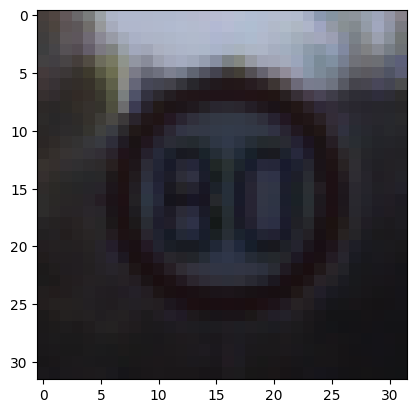

In [7]:
for img,label in train_loader:
    img = to_image(img[0])
    plt.imshow(img)
    print(LABELS[label[0]])
    break

In [8]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        x = torch.zeros((64,3,_N,_N))
        self.activation = torch.nn.functional.relu
        self.pool = torch.nn.MaxPool2d(2,2)

        self.conv1 = torch.nn.Conv2d(3,6,5)
        x = self.pool(self.activation(self.conv1(x)))
        
        self.conv2 = torch.nn.Conv2d(x.shape[1],16,5)
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        self.dense1 = torch.nn.Linear(x.shape[1],128)
        x = self.activation(self.dense1(x))
        self.dense2 = torch.nn.Linear(x.shape[1],64)
        x = self.activation(self.dense2(x))
        self.final = torch.nn.Linear(x.shape[1],n_classes)


    def forward(self,x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        x = self.final(x)

        return x
        
model = torch.compile(Model()).to(device)
summary(model,(3,32,32),batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [256, 6, 28, 28]             456
         MaxPool2d-2           [256, 6, 14, 14]               0
            Conv2d-3          [256, 16, 10, 10]           2,416
         MaxPool2d-4            [256, 16, 5, 5]               0
            Linear-5                 [256, 128]          51,328
            Linear-6                  [256, 64]           8,256
            Linear-7                  [256, 43]           2,795
             Model-8                  [256, 43]               0
Total params: 65,251
Trainable params: 65,251
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/backward pass size (MB): 15.93
Params size (MB): 0.25
Estimated Total Size (MB): 19.18
----------------------------------------------------------------


In [9]:
loss_func = torch.nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.Adam(model.parameters())#torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

In [10]:

def train(model,loss_func,optimiser):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss {total_loss / len(train_loader):.3f}")

In [11]:
train(model,loss_func,optimiser)

Epoch 1: Loss 2.709
Epoch 2: Loss 0.924
Epoch 3: Loss 0.502
Epoch 4: Loss 0.337
Epoch 5: Loss 0.252
Epoch 6: Loss 0.190
Epoch 7: Loss 0.152
Epoch 8: Loss 0.124
Epoch 9: Loss 0.100
Epoch 10: Loss 0.085
Epoch 11: Loss 0.073
Epoch 12: Loss 0.064
Epoch 13: Loss 0.054
Epoch 14: Loss 0.046
Epoch 15: Loss 0.039
Epoch 16: Loss 0.039
Epoch 17: Loss 0.033
Epoch 18: Loss 0.025
Epoch 19: Loss 0.026
Epoch 20: Loss 0.023
Epoch 21: Loss 0.028
Epoch 22: Loss 0.027
Epoch 23: Loss 0.023
Epoch 24: Loss 0.022
Epoch 25: Loss 0.012
Epoch 26: Loss 0.009
Epoch 27: Loss 0.009
Epoch 28: Loss 0.007
Epoch 29: Loss 0.007
Epoch 30: Loss 0.030


In [12]:
def evaluate(model):
    predictions = []
    labels = []
    with torch.no_grad():
        for images,lbls in test_loader:
            labels.extend(lbls.numpy())
            
            images = images.to(device)
            preds = model(images)
            predictions.extend(preds.cpu().numpy())
            
    labels = np.array(labels)
    predictions = np.array(predictions)
    pred_class = np.argmax(predictions,axis=1)
    precision = precision_score(labels, pred_class, average="weighted")
    recall = recall_score(labels, pred_class, average="weighted")
    f1 = f1_score(labels, pred_class, average="weighted")
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')
evaluate(model)

Precision (macro): 0.9798
Recall (macro): 0.9790
F1-score (macro): 0.9791


In [13]:
#@torch.compile
def pgd_attack(model,images,labels,loss_func,iterations,epsilon,alpha):
    
    adversarial = denormalise(images)
    lower_bound = adversarial - epsilon
    upper_bound = adversarial + epsilon
    
    decay = torch.logspace(alpha,1,iterations,2)
    decay = decay / decay[0]

    for alpha in decay:
        normalised = normalise(adversarial)
        normalised.requires_grad = True
        model.zero_grad()
        pred = model(normalised)
        loss = loss_func(pred,labels)
        #print(loss.item())
        loss.backward()
        # TODO - Edit Learning Rate / Apply Adam Optimiser
        perturbations = torch.sign(normalised.grad.data) * epsilon * alpha
        adversarial += perturbations
        adversarial = torch.clip(adversarial,lower_bound, upper_bound)
        adversarial = torch.clip(adversarial,0,1)

    return normalise(adversarial)

normalise.to(device)

@torch.compile
def denormalise(images):
    _mean = mean.view(1,3,1,1).to(device)
    _std = std.view(1,3,1,1).to(device)
    return img * _std + _mean

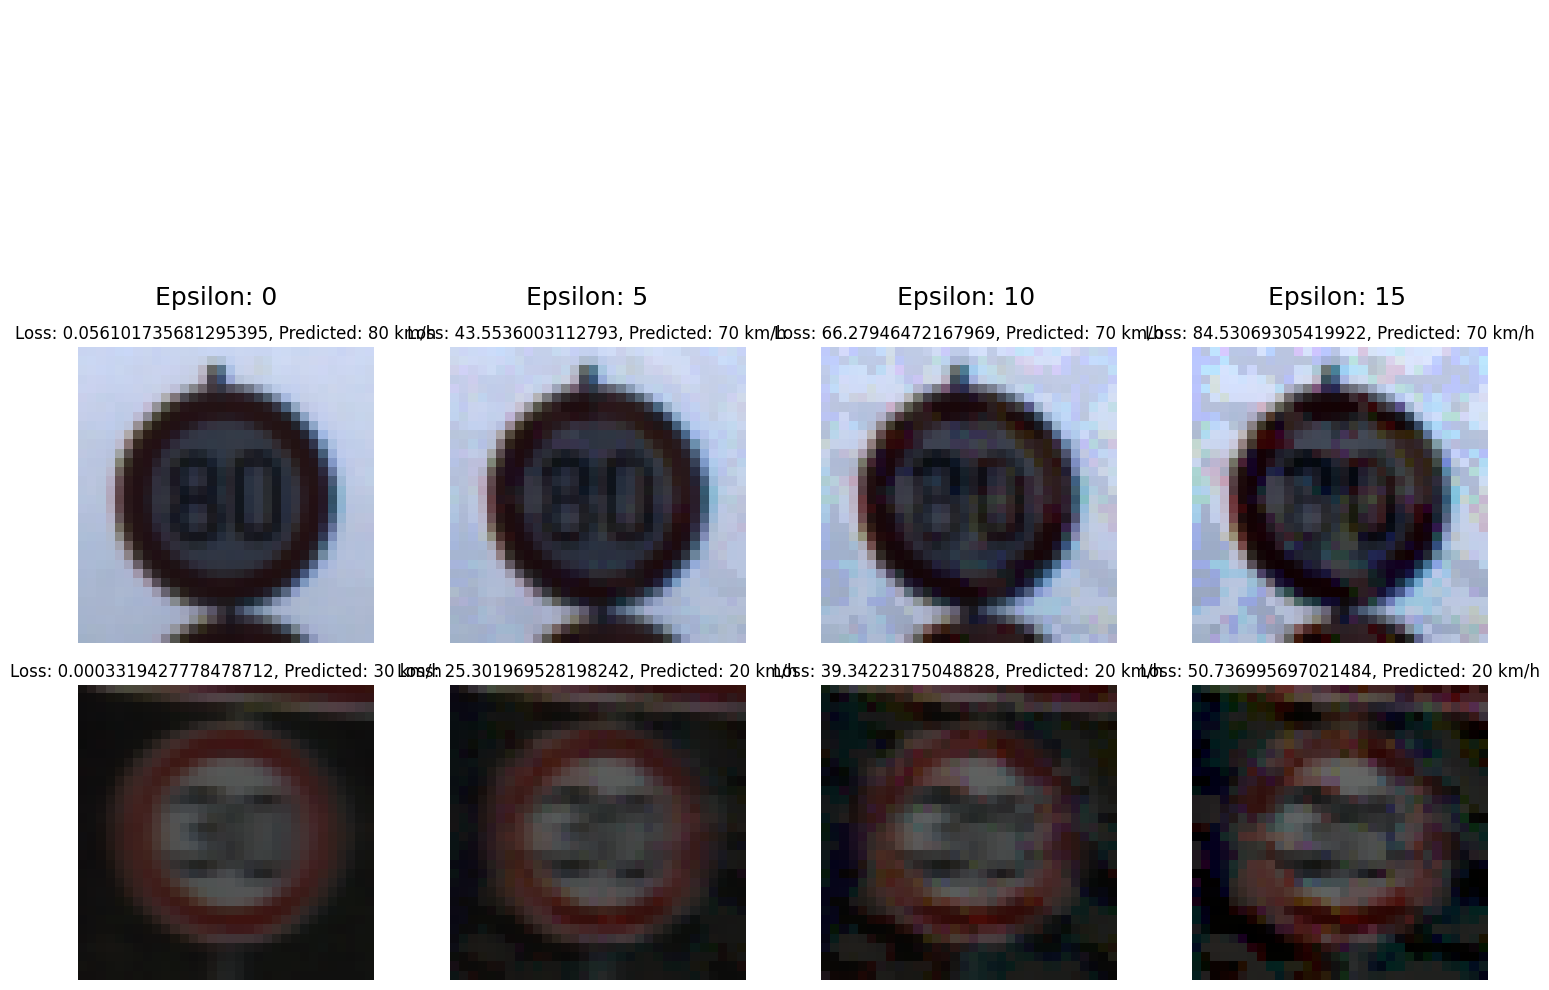

In [14]:
for img,lbl in test_loader:
    img = img.to(device)
    lbl = lbl.to(device)

    """og_pred = model(img)
    adv_pred = model(adv)
    og_loss = loss_func()"""
    #print(f"Set: {epsilon}\nActual: {torch.max(denormalise(img)-denormalise(adv))}")

    rows = 3
    columns = 4
    
    plt.figure(figsize=(15, 10))

    for j in range(columns):
        epsilon = j * 5
        plt.subplot(rows, columns, j + 1)
        plt.axis("off")
        plt.text(0.3, 0, f"Epsilon: {epsilon}", fontsize=18)

        

    for j in range(columns):
        epsilon = j * 5 / 255
        adv = pgd_attack(model,img,lbl,loss_func,50,epsilon,2)
        for i in range(1,rows):
            plt.subplot(rows, columns, i * columns + j + 1)
            pred = model(adv[i].reshape(1,3,_N,_N))
            loss = loss_func(pred,lbl[i].reshape(1)).data
            pred_class = LABELS[torch.argmax(pred)]
            plt.imshow(to_image(adv[i].cpu()))
            plt.title(f"Loss: {loss}, Predicted: {pred_class}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()
 
    break

In [ ]:
def adversarial_train(model,loss_func,optimiser):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss {total_loss / len(train_loader):.3f}")
